
# ***From Pixels to Decisions***

- Preprocess Sentinel-2,
- compute *NDVI/NDWI*,
- integrate *CHIRPS rainfall anomalies*,
- Calculate *Temperature*
- Intergrate ground Truth data and Satellite Indices  
- Give an example of Google Alpha earth Embeddings




## **`1) Imports`**

In [ ]:

import ee
import geemap
import pandas as pd
import geopandas as gpd
import numpy as np
import datetime as dt
from shapely import wkt
import geopandas as gpd
import json
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.dates import AutoDateLocator, ConciseDateFormatter

print("Libraries imported.")


Libraries imported.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **`2) Authenticate & Initialize Earth Engine`**

In [ ]:
#Service Account Details
path1 = '/content/drive/MyDrive/PERSONAL/Pry'

In [ ]:
#---- Initialize Earth Engine
service_account = 'stephen-kory@ee-stephenkorykorir.iam.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account, path1+'/params.json')
ee.Initialize(credentials)
print('Initialized')

Initialized



## **`3) Choose an Area of Interest (AOI)`**

- Load in the example farm Polygons [ECAAS Link](https://ecaas.pula.io/)
- Load in an Area of Interest `Uasin Gishu`


In [ ]:
data = "/content/drive/MyDrive/PROJECTS/ai for startups/01_Data/uasin_yield2 (1).csv"
path = "/content/drive/MyDrive/PROJECTS/ai for startups/01_Data/gadm41_KEN_1.shp"

df1 = pd.read_csv(data)
df = df1.copy()
df.shape

NameError: name 'pd' is not defined

In [ ]:
#Filter out and get Uain Gishu County from Counties ahapefile
aoi = gpd.read_file(path)
aoi = aoi[aoi['NAME_1']== 'Uasin Gishu']
aoi.head()
aoi = aoi.rename(columns={'HASC_1': 'Case_ID'})

In [ ]:
#Filter out to get Maize data only
df = df[df['Crop_Type']== 'Maize']
df.head()

In [ ]:
df.shape

In [ ]:
# Create a GeoDataFrame from the DataFrame
try:
    gdf = gpd.GeoDataFrame(df, geometry=df['Farm_Polygon'].apply(wkt.loads))
    print("\nGeoDataFrame created successfully!")
    display(gdf.head(1))
except Exception as e:
    print(f"Error creating GeoDataFrame: {e}")

In [ ]:
def geodataframe_to_featurecollection(gdf):
    """Converts a GeoDataFrame to an Earth Engine FeatureCollection."""
    print("Converting GeoDataFrame to Earth Engine FeatureCollection...")
    features = []
    for index, row in gdf.iterrows():
        # Get the Shapely geometry object
        shapely_geometry = row['geometry']
        # Convert Shapely geometry to GeoJSON dictionary
        geojson_geometry = shapely_geometry.__geo_interface__
        # Convert GeoJSON dictionary to ee.Geometry
        ee_geometry = ee.Geometry(geojson_geometry)

        # Use a unique ID for each feature, here assuming 'ID'
        feature = ee.Feature(
            ee_geometry,
            {'ID': row['Case_ID']}
        )
        features.append(feature)

    feature_collection = ee.FeatureCollection(features)
    print("Conversion complete.")
    return feature_collection

In [ ]:
#Transforming the farm polygons to Earth Engine Featurecollection
polygons_ee = geodataframe_to_featurecollection(gdf)


NameError: name 'geodataframe_to_featurecollection' is not defined

In [ ]:
#Transforming the AOI to Featurecollection
aoi = geodataframe_to_featurecollection(aoi)

In [ ]:
#Let us map them the area of Interest and Farm Polygons


Map = geemap.Map(center=[0.40, 35.30], zoom=9)
Map.addLayer(aoi, {}, "AOI")
Map.addLayer(polygons_ee, {"color": "yellow"}, "Farm polygons")
Map



## **`4) Sentinel-2 Preprocessing & Indices (NDVI, NDWI)`**

- Data: `COPERNICUS/S2_SR_HARMONIZED`
- Cloud mask: simple QA60 bitmask
- Composite by date range
- Indices:
  - **NDVI** = (B8 - B4) / (B8 + B4)  

  - **NDWI** = (B3 - B8) / (B3 + B8)  

  - **NDMI** = (B8 - B11) / (B8 + B11)


In [ ]:

start = '2021-05-01'
end   = '2021-08-31'

def mask_s2_sr(image):
    qa = image.select('QA60')
    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))
    return image.updateMask(mask).copyProperties(image, ['system:time_start'])

s2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
      .filterBounds(aoi)
      .filterDate(start, end)
      .map(mask_s2_sr))

# Median composite
s2_med = s2.median().clip(aoi)

# Indices
ndvi = s2_med.normalizedDifference(['B8', 'B4']).rename('NDVI')
ndwi = s2_med.normalizedDifference(['B3', 'B8']).rename('NDWI')
ndmi = s2_med.normalizedDifference(['B8', 'B11']).rename('NDMI')

vis_rgb = {'bands': ['B4','B3','B2'], 'min': 0, 'max': 3000}
vis_ndvi = {'min': -0.2, 'max': 0.9, 'palette': ['#d73027','#fee08b','#1a9850']}
vis_ndwi = {'min': -0.5, 'max': 0.7, 'palette': ['#fdae61','#abd9e9','#2c7bb6']}
vis_ndmi = {'min': -0.5, 'max': 0.7, 'palette': ['#f46d43','#fdae61','#74add1','#4575b4']}

Map.addLayer(s2_med, vis_rgb, 'S2 RGB (median)')
Map.addLayer(ndvi, vis_ndvi, 'NDVI')
Map.addLayer(ndwi, vis_ndwi, 'NDWI')
Map.addLayer(ndmi, vis_ndmi, 'NDMI')
Map


Map(bottom=522844.0, center=[0.5987410590368043, 35.050850822407774], controls=(WidgetControl(options=['positi…


## **`5) Climate Integration: CHIRPS Rainfall & Anomalies`**

- Dataset: `UCSB-CHG/CHIRPS/DAILY`  
- Compute rainfall **sum** for the analysis period (e.g., May–Aug 2021) >> Make sure it falls within the time period of the farm data collection.  
- Compute **historical baseline** (same months across multiple years, e.g., 2015–2020) and get an anomaly:  



In [ ]:

# Current period rainfall
chirps = (ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')
          .filterBounds(polygons_ee)
          .filterDate(start, end))

rain_current = chirps.select('precipitation').sum().rename('rain_sum')

# Historical baseline for same months (2015-2020)
hist_start = '2015-05-01'
hist_end   = '2020-08-31'
chirps_hist = (ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')
               .filterBounds(aoi)
               .filterDate(hist_start, hist_end))

def is_may_to_aug(img):
    d = ee.Date(img.get('system:time_start'))
    m = d.get('month')
    return img.updateMask(m.gte(5).And(m.lte(8)))

chirps_hist_may_aug = chirps_hist.map(is_may_to_aug)
rain_hist_mean = chirps_hist_may_aug.select('precipitation').sum().divide(6).rename('rain_hist_mean')  # 6 seasons 2015-2020

rain_anom = rain_current.subtract(rain_hist_mean).rename('rain_anom')

vis_rain = {'min': 0, 'max': 600, 'palette': ['#ffffcc','#a1dab4','#41b6c4','#2c7fb8','#253494']}
vis_anom = {'min': -200, 'max': 200, 'palette': ['#a50026','#f46d43','#fdae61','#abd9e9','#74add1','#4575b4']}

Map.addLayer(rain_current.clip(aoi), vis_rain, 'Rainfall May–Aug 2024 (mm)')
Map.addLayer(rain_anom.clip(aoi), vis_anom, 'Rainfall Anomaly (vs 2015–2020)')
Map


Map(bottom=130805.0, center=[0.7786320384912766, 35.53665161132813], controls=(WidgetControl(options=['positio…


## **`6) ERA5-Land Temperature (Monthly)`**

- Dataset: `ECMWF/ERA5_LAND/MONTHLY_AGGR`
- Extract mean 2m air temperature for the period and compute mean.


In [ ]:

era5 = (ee.ImageCollection('ECMWF/ERA5_LAND/MONTHLY_AGGR')
        .filterBounds(aoi)
        .filterDate(start,end))

t2m_mean = era5.select('temperature_2m').mean().rename('t2m_mean')
Map.addLayer(t2m_mean.clip(aoi), {'min': 280, 'max': 305}, 'ERA5-Land T2m Mean (K)')
Map


Map(bottom=130774.0, center=[0.8212057617878383, 35.63696326642068], controls=(WidgetControl(options=['positio…


## **`7) Extract Features Over Farm Polygons >> For ML/Yield etc`**

We compute zonal statistics for each farm:
- NDVI mean, NDWI mean, NDMI mean
- Rainfall sum and anomaly
- temperature mean

Results are exported to a Pandas DataFrame for ML.


In [ ]:

stack = ndvi.addBands([ndwi, ndmi, rain_current, rain_anom, t2m_mean])

# Reduce over polygons
reducers = ee.Reducer.mean().combine(ee.Reducer.stdDev(), sharedInputs=True).combine(ee.Reducer.min(), sharedInputs=True).combine(ee.Reducer.max(), sharedInputs=True)

reduced = stack.reduceRegions(
    collection=polygons_ee,
    reducer=reducers,
    scale=10,
    tileScale=4
)

# Bring to client as GeoJSON-like dict >> for many features use Export.table.toDrive
fc_dict = reduced.getInfo()
rows = []
for f in fc_dict['features']:
    props = f['properties']
    props['ID'] = props.get('ID')
    rows.append(props)

df = pd.DataFrame(rows)
df = df.rename(columns=lambda c: c.replace(':', '_'))
df.head()


ID  NDMI_max  NDMI_mean  NDMI_min  \
0  568fe8ee-87d4-4a2e-baba-4b82d153cc49  0.068690   0.033806 -0.011174   
1  a075c5af-969a-4b5c-8759-1d50f7adeb07  0.200420   0.131584  0.069528   
2  4874b8b4-f255-42e2-a828-51086f8f672d  0.121375   0.051337 -0.004636   
3  77becb5a-48e2-4816-9b48-f535b8c05c9a  0.311692   0.205397  0.031253   
4  04f2831b-2429-4b00-ab2b-f10315c28a6f       NaN        NaN       NaN   

   NDMI_stdDev  NDVI_max  NDVI_mean  NDVI_min  NDVI_stdDev  NDWI_max  ...  \
0     0.022328  0.567194   0.476150  0.252926     0.076037 -0.325081  ...   
1     0.036832  0.717371   0.575562  0.477265     0.058284 -0.545312  ...   
2     0.043781  0.650287   0.561449  0.494357     0.038141 -0.523048  ...   
3     0.054276  0.753073   0.680946  0.531608     0.050611 -0.546405  ...   
4          NaN       NaN        NaN       NaN          NaN       NaN  ...   

   rain_anom_min  rain_anom_stdDev  rain_sum_max  rain_sum_mean  rain_sum_min  \
0     -96.187168          0.000003    602.340921     602.340921    602.340921   
1     -62.845494          0.000001    616.952416     616.952416    616.952416   
2     -94.576812          0.000000    682.624448     682.624448    682.624448   
3    -100.525002          0.000000    630.657661     630.657661    630.657661   
4     -62.845494          0.000000    616.952416     616.952416    616.952416   

   rain_sum_stdDev  t2m_mean_max  t2m_mean_mean  t2m_mean_min  t2m_mean_stdDev  
0         0.000000    289.590336     289.590336    289.590336         0.000011  
1         0.000023    290.734662     290.734662    290.734662         0.000007  
2         0.000010    287.623127     287.623127    287.623127         0.000004  
3         0.000000    289.892392     289.892392    289.892392         0.000000  
4         0.000019    290.734662     290.734662    290.734662         0.000034  

[5 rows x 25 columns]


## **`8) Save Outputs`**

- `features_for_ml.csv` with per-farm metrics and labels/clusters.
- Use these for downstream dashboards or model training.


In [ ]:
# Extract Case_ID and Yield from df1
yield_data = df1[['Case_ID', 'Yield(Mt/ha)']].copy()

# Rename Case_ID to ID in yield_data
yield_data = yield_data.rename(columns={'Case_ID': 'ID'})

# Merge df with yield_data on 'ID'
df = pd.merge(df, yield_data, on='ID', how='inner')

df.head()

ID  NDMI_max  NDMI_mean  NDMI_min  \
0  568fe8ee-87d4-4a2e-baba-4b82d153cc49  0.068690   0.033806 -0.011174   
1  a075c5af-969a-4b5c-8759-1d50f7adeb07  0.200420   0.131584  0.069528   
2  4874b8b4-f255-42e2-a828-51086f8f672d  0.121375   0.051337 -0.004636   
3  77becb5a-48e2-4816-9b48-f535b8c05c9a  0.311692   0.205397  0.031253   
4  04f2831b-2429-4b00-ab2b-f10315c28a6f       NaN        NaN       NaN   

   NDMI_stdDev  NDVI_max  NDVI_mean  NDVI_min  NDVI_stdDev  NDWI_max  ...  \
0     0.022328  0.567194   0.476150  0.252926     0.076037 -0.325081  ...   
1     0.036832  0.717371   0.575562  0.477265     0.058284 -0.545312  ...   
2     0.043781  0.650287   0.561449  0.494357     0.038141 -0.523048  ...   
3     0.054276  0.753073   0.680946  0.531608     0.050611 -0.546405  ...   
4          NaN       NaN        NaN       NaN          NaN       NaN  ...   

   rain_anom_stdDev  rain_sum_max  rain_sum_mean  rain_sum_min  \
0          0.000003    602.340921     602.340921    602.340921   
1          0.000001    616.952416     616.952416    616.952416   
2          0.000000    682.624448     682.624448    682.624448   
3          0.000000    630.657661     630.657661    630.657661   
4          0.000000    616.952416     616.952416    616.952416   

   rain_sum_stdDev  t2m_mean_max  t2m_mean_mean  t2m_mean_min  \
0         0.000000    289.590336     289.590336    289.590336   
1         0.000023    290.734662     290.734662    290.734662   
2         0.000010    287.623127     287.623127    287.623127   
3         0.000000    289.892392     289.892392    289.892392   
4         0.000019    290.734662     290.734662    290.734662   

   t2m_mean_stdDev  Yield(Mt/ha)  
0         0.000011          5.59  
1         0.000007          5.11  
2         0.000004          3.00  
3         0.000000          2.28  
4         0.000034          4.07  

[5 rows x 26 columns]

In [ ]:

out_path = 'features_for_ml.csv'
df.to_csv(out_path, index=False)
print("Saved:", out_path)


Saved: features_for_ml.csv


## **`9. Crop Monitoring`**

In [ ]:
# getting the S2 collection

s2

### `Calculate indices for each image`


In [ ]:
def add_indices(image):
    """Calculates and adds NDVI and NDMI bands to a Sentinel-2 image."""
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    ndmi = image.normalizedDifference(['B8', 'B11']).rename('NDMI')
    return image.addBands([ndvi, ndwi, ndmi])

s2_with_indices = s2.map(add_indices)

### `Reduce data over polygons`

In [ ]:
## Reduce data over polygons
def reduce_indices_over_farms(image):
    """Reduces NDVI,NDMI bands over farm polygons."""
    date = image.get('system:time_start')
    reduced_image = image.select(['NDVI', 'NDMI']).reduceRegions(
        collection=polygons_ee.limit(5),
        reducer=ee.Reducer.mean(),
        scale=10,
        tileScale=4
    )
    print()
    # Add the date to each feature in the reduced collection
    def add_date(feature):
        return feature.set('date', ee.Date(date).format('YYYY-MM-dd'))
    return reduced_image.map(add_date)

# Map the reduction function over the collection and flatten the results
reduced_collection = s2_with_indices.map(reduce_indices_over_farms).flatten()
filtered_collection = reduced_collection.filter(ee.Filter.notNull(['NDVI']))

# Get the results from Earth Engine
reduced_list = filtered_collection.getInfo()


###`Convert the list of reduced features into a Pandas DataFrame for easier manipulation and analysis.`



In [ ]:
rows = []
for f in reduced_list['features']:
    props = f['properties']
    rows.append(props)

time_series_df = pd.DataFrame(rows)
time_series_df['date'] = pd.to_datetime(time_series_df['date'])
time_series_df = time_series_df.rename(columns=lambda c: c.replace(':', '_'))
time_series_df.head()

ID      NDMI      NDVI       date
0  568fe8ee-87d4-4a2e-baba-4b82d153cc49 -0.092485  0.234832 2021-05-01
1  a075c5af-969a-4b5c-8759-1d50f7adeb07 -0.127025  0.228931 2021-05-01
2  4874b8b4-f255-42e2-a828-51086f8f672d -0.134447  0.295999 2021-05-01
3  77becb5a-48e2-4816-9b48-f535b8c05c9a -0.136604  0.288204 2021-05-01
4  04f2831b-2429-4b00-ab2b-f10315c28a6f -0.037362  0.154370 2021-05-01

### `Visualize time series`



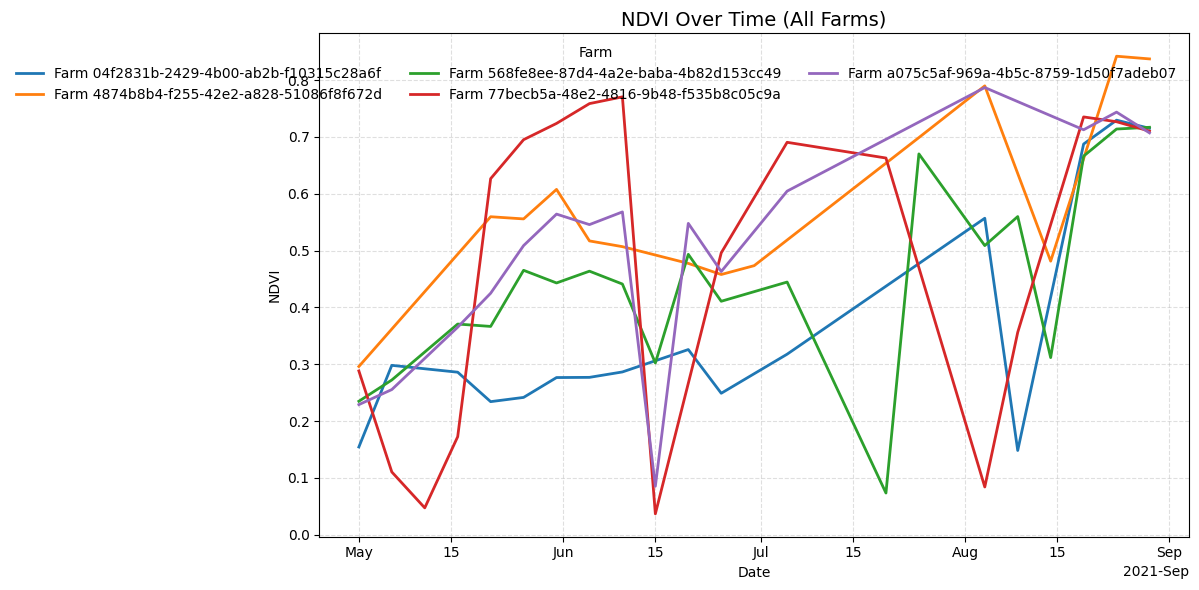

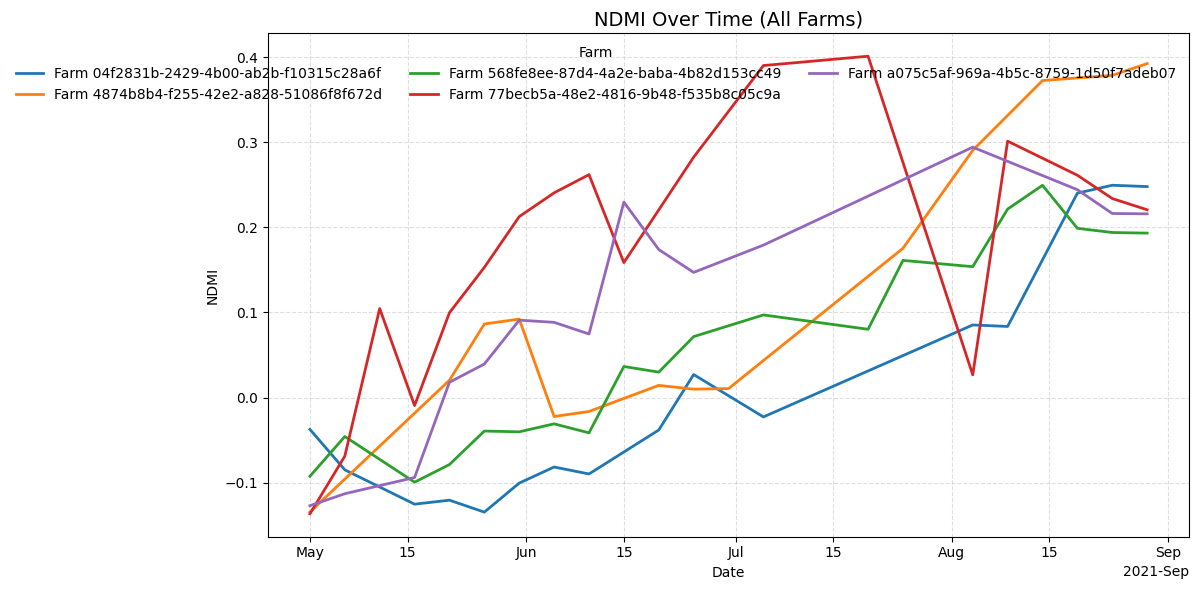

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator, ConciseDateFormatter

# Ensure correct dtypes & ordering
time_series_df = time_series_df.copy()
time_series_df['date'] = pd.to_datetime(time_series_df['date'])

time_series_df = time_series_df.sort_values(['ID', 'date'])

def plot_metric(df, metric, title):
    fig, ax = plt.subplots(figsize=(12, 6))
    for farm_id, g in df.groupby('ID'):
        ax.plot(g['date'], g[metric], label=f'Farm {farm_id}', linewidth=2)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Date')
    ax.set_ylabel(metric)
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.legend(title='Farm', ncol=3, frameon=False)

    # nicer date axis
    locator = AutoDateLocator()
    formatter = ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    plt.tight_layout()
    plt.show()

# --- Plot the two charts ---
plot_metric(time_series_df, 'NDVI', 'NDVI Over Time ')
plot_metric(time_series_df, 'NDMI', 'NDMI Over Time ')


In [ ]:
window_size = 5
time_series_df['NDVI_smooth'] = time_series_df.groupby('ID')['NDVI'].rolling(window=window_size, center=True).mean().reset_index(level=0, drop=True)
time_series_df['NDMI_smooth'] = time_series_df.groupby('ID')['NDMI'].rolling(window=window_size, center=True).mean().reset_index(level=0, drop=True)

time_series_df.head(2)

ID      NDMI      NDVI       date  \
4  04f2831b-2429-4b00-ab2b-f10315c28a6f -0.037362  0.154370 2021-05-01   
8  04f2831b-2429-4b00-ab2b-f10315c28a6f -0.084899  0.298034 2021-05-06   

   NDVI_smooth  NDMI_smooth  date_str  
4          NaN          NaN  2021-May  
8          NaN          NaN  2021-May

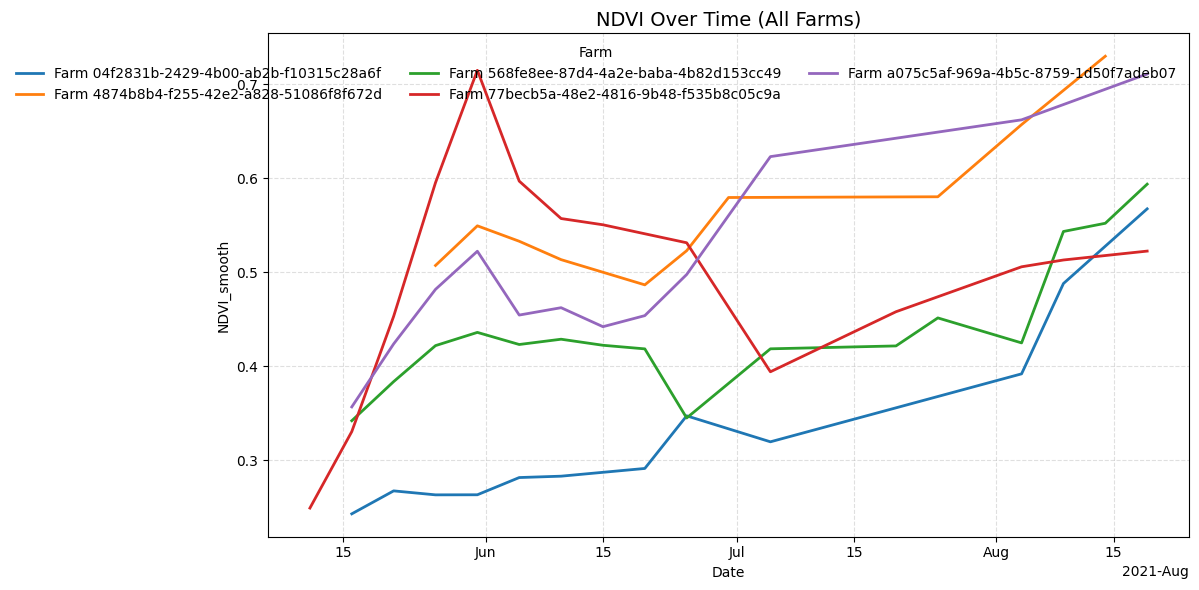

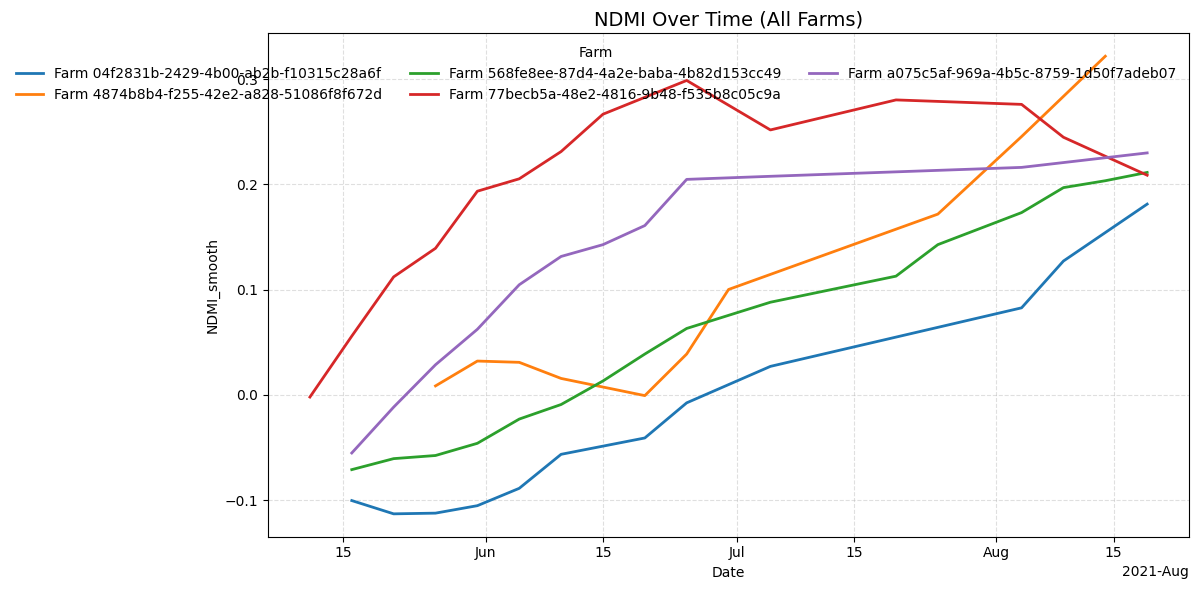

In [ ]:


# Ensure correct dtypes and ordering
time_series_df = time_series_df.copy()
time_series_df['date'] = pd.to_datetime(time_series_df['date'])
time_series_df = time_series_df.sort_values(['ID', 'date'])

def plot_metric(df, metric, title):
    fig, ax = plt.subplots(figsize=(12, 6))
    for farm_id, g in df.groupby('ID'):
        ax.plot(g['date'], g[metric], label=f'Farm {farm_id}', linewidth=2)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Date')
    ax.set_ylabel(metric)
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.legend(title='Farm', ncol=3, frameon=False)

    # nicer date axis
    locator = AutoDateLocator()
    formatter = ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    plt.tight_layout()
    plt.show()

# --- Plot the two charts ---
plot_metric(time_series_df, 'NDVI_smooth', 'NDVI Over Time (All Farms)')
plot_metric(time_series_df, 'NDMI_smooth', 'NDMI Over Time (All Farms)')





## **`10. Embeddings >> Cropland Mapping`**

In [ ]:

year = 2021
num_samples = 5000
scale = 10

bands = [f"A{str(i).zfill(2)}" for i in range(64)]
emb_coll = ee.ImageCollection("GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL").filterDate(f"{year}-01-01", f"{year+1}-01-01").filterBounds(aoi)

emb_img = ee.Image(emb_coll.first()).select(bands).clip(aoi)
print("Got embedding image for year:", year)


Got embedding image for year: 2021


### `Quick Look Map`

In [ ]:
vis = {'min': -0.3, 'max': 0.3, 'bands': ['A01','A16','A09']}
Map.addLayer(emb_img, vis, f"Embeddings {year} (RGB of 3 axes)")
Map.addLayer(aoi, {}, "AOI")
Map

Map(bottom=65574.0, center=[0.7182240952087022, 36.04897094018928], controls=(WidgetControl(options=['position…

### `Sample Embeddings`

In [ ]:

sample_fc = emb_img.sample(region=aoi, scale=scale, numPixels=num_samples, geometries=False, tileScale=4)
sample = sample_fc.getInfo()
X = np.array([[feat['properties'][b] for b in bands] for feat in sample['features']], dtype=float)
print("Sample shape:", X.shape)


Sample shape: (4999, 64)


In [ ]:
print(X[2])

[ 1.08512111e-01  2.22068435e-02  1.79377163e-01 -4.82276048e-02
  2.97731642e-02  1.77777778e-02  5.91157247e-02  1.08512111e-01
  1.03406382e-01 -1.72795079e-01 -9.84236832e-02 -1.41730104e-01
  1.77777778e-02 -6.15148020e-03  0.00000000e+00 -1.24567474e-01
 -2.14133026e-01  6.29911572e-02  6.15148020e-05  1.53787005e-01
 -9.84236832e-02 -6.69896194e-02  2.28896578e-01 -1.38408304e-02
 -1.41730104e-01 -9.35640138e-02  9.35640138e-02  2.97731642e-02
 -3.25413303e-02 -1.20569012e-02 -2.28896578e-01 -5.91157247e-02
 -2.67958478e-01 -7.97231834e-02 -2.46059208e-02 -2.14133026e-01
  5.17339485e-02 -1.60000000e-01  5.17339485e-02  1.03406382e-01
  3.25413303e-02 -8.42137639e-02 -3.64721261e-01 -5.53633218e-02
 -1.03960015e-02 -7.97231834e-02 -5.91157247e-02 -7.53556324e-02
 -1.35886198e-01 -1.20569012e-02  2.46059208e-02  1.19092657e-01
 -1.08512111e-01  1.72795079e-01  1.72795079e-01  4.48442907e-02
  1.60000000e-01  8.42137639e-02 -3.27812380e-01 -1.53787005e-01
 -1.35886198e-01 -1.03960

### `Calculate the Aggregate Similiraty Index`

In [ ]:
# Calculate the mean embedding vector across ALL polygons in the collection
# Merge the polygons into a single geometry
merged_polygons_geometry = polygons_ee.geometry()

# Calculate the mean embedding vector over the merged geometry
aggregate_embedding_dict = emb_img.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=merged_polygons_geometry,  # Use the merged geometry
    scale=scale,
    maxPixels=1e9
)

# Extract the resulting average vector using the actual band names
aggregate_vector_list = [aggregate_embedding_dict.get(band) for band in bands]

# Convert the list to an Earth Engine Array
aggregate_vector = ee.Array(aggregate_vector_list)


print("Aggregate embedding vector:", aggregate_vector.getInfo())

Aggregate embedding vector: [0.00399847225126396, 0.012363068848092993, 0.1440115573362032, -0.0368812204400006, -0.04180911474839965, -0.003529634779943647, -0.0270125321802435, 0.03758176407828665, 0.09876910278082231, -0.17686312153034492, -0.03662973575535286, -0.1402569885095984, -0.06992832050442119, 0.036380970028832484, -0.07475729824990185, -0.14118138033022173, -0.21375287378569383, 0.004935060651057059, -0.03657889990086092, 0.08209069607904693, -0.11286813349194884, 0.07800081733639275, 0.19863728939588668, 0.0024991717582804264, -0.10303068339560577, -0.044569764377404016, 0.07434825546609435, -0.0023901921778734523, 0.005955049356695491, -0.0136759263688218, -0.16467560054061223, 0.06603062284053307, -0.23796115999258724, -0.051511986199495104, 0.011607985915634627, -0.2642569292702252, -0.012860248429977392, -0.06407030639020143, 0.1007813011997816, 0.06551454229847074, -0.0681190454971712, -0.068772606504784, -0.281766353808264, -0.1497242620636814, -0.06589357572554437

### `Compute and Visualize the Similarity Map`

In [ ]:
# Compute cosine similarity using the aggregate vector

aggregate_image = ee.Image.constant(aggregate_vector.getInfo()).rename(bands)

# Calculate dot product (A * B)
dot_product = emb_img.multiply(aggregate_image).reduce('sum')

# Calculate magnitudes
magnitude_emb = emb_img.pow(2).reduce('sum').sqrt()
magnitude_aggregate = aggregate_image.pow(2).reduce('sum').sqrt()

# Calculate cosine similarity
similarity_map = dot_product.divide(magnitude_emb.multiply(magnitude_aggregate)).rename('similarity')


# Create an interactive map
Map = geemap.Map()
Map.centerObject(polygons_ee, 7)

# Define visualization parameters
similarity_vis_params = {
    'min': 0.7,
    'max': 1.0,
    'palette': ['#000000', '#FFFF00', '#00FF00', '#FFFFFF'] # Black -> Yellow -> Green -> White
}

# Add layers to the map
Map.addLayer(polygons_ee, {'color': 'blue'}, 'All Farm Polygons')
Map.addLayer(similarity_map, similarity_vis_params, 'Similarity to Average Farm')

# Display the map
Map

Map(center=[0.6403995919147304, 35.36709227419623], controls=(WidgetControl(options=['position', 'transparent_…